In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error, mutual_info_score
import xgboost as xgb

from IPython.display import display
import requests

In [2]:
df = pd.read_csv("stroke_prediction_dataset.csv")

In [3]:
df.columns

Index(['Patient ID', 'Patient Name', 'Age', 'Gender', 'Hypertension',
       'Heart Disease', 'Marital Status', 'Work Type', 'Residence Type',
       'Average Glucose Level', 'Body Mass Index (BMI)', 'Smoking Status',
       'Alcohol Intake', 'Physical Activity', 'Stroke History',
       'Family History of Stroke', 'Dietary Habits', 'Stress Levels',
       'Blood Pressure Levels', 'Cholesterol Levels', 'Symptoms', 'Diagnosis'],
      dtype='object')

In [4]:
df.head()

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


In [5]:
del df["Patient ID"]
del df["Patient Name"]
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [6]:
df.describe()

,age,hypertension,heart_disease,average_glucose_level,body_mass_index_(bmi),stroke_history,stress_levels
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,54.035667,0.249000,0.502933,129.445209,27.474302,0.500267,5.022694
std,21.063111,0.432448,0.500008,40.487792,7.230201,0.500017,2.873223
min,18.000000,0.000000,0.000000,60.000000,15.010000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,94.517500,21.160000,0.000000,2.540000
50%,54.000000,0.000000,1.000000,128.900000,27.420000,1.000000,5.050000
75%,72.000000,0.000000,1.000000,164.592500,33.720000,1.000000,7.520000
max,90.000000,1.000000,1.000000,200.000000,40.000000,1.000000,10.000000


In [7]:
df.dtypes

age                           int64
gender                       object
hypertension                  int64
heart_disease                 int64
marital_status               object
work_type                    object
residence_type               object
average_glucose_level       float64
body_mass_index_(bmi)       float64
smoking_status               object
alcohol_intake               object
physical_activity            object
stroke_history                int64
family_history_of_stroke     object
dietary_habits               object
stress_levels               float64
blood_pressure_levels        object
cholesterol_levels           object
symptoms                     object
diagnosis                    object
dtype: object

In [8]:
df.isna().sum()

age                            0
gender                         0
hypertension                   0
heart_disease                  0
marital_status                 0
work_type                      0
residence_type                 0
average_glucose_level          0
body_mass_index_(bmi)          0
smoking_status                 0
alcohol_intake                 0
physical_activity              0
stroke_history                 0
family_history_of_stroke       0
dietary_habits                 0
stress_levels                  0
blood_pressure_levels          0
cholesterol_levels             0
symptoms                    2500
diagnosis                      0
dtype: int64

In [9]:
df['symptoms'] = df['symptoms'].fillna("No symptoms")
df['diagnosis'] = (df['diagnosis'] == "Stroke").astype(int)

In [10]:
df["diagnosis"].value_counts()

diagnosis
0    7532
1    7468
Name: count, dtype: int64

In [11]:
global_mean = df["diagnosis"].mean()
global_mean

0.4978666666666667

In [12]:
df.nunique()

age                           73
gender                         2
hypertension                   2
heart_disease                  2
marital_status                 3
work_type                      4
residence_type                 2
average_glucose_level       9215
body_mass_index_(bmi)       2490
smoking_status                 3
alcohol_intake                 4
physical_activity              3
stroke_history                 2
family_history_of_stroke       2
dietary_habits                 7
stress_levels               1001
blood_pressure_levels       4458
cholesterol_levels          5952
symptoms                    5787
diagnosis                      2
dtype: int64

In [13]:
# CONSTANTS
to_remove = ["blood_pressure_levels", "cholesterol_levels", "symptoms"]

categorical = df.select_dtypes(include='object').columns.tolist()

for item in to_remove:
    categorical.remove(item)
categorical

['gender',
 'marital_status',
 'work_type',
 'residence_type',
 'smoking_status',
 'alcohol_intake',
 'physical_activity',
 'family_history_of_stroke',
 'dietary_habits']

In [14]:

for col in categorical:
    df_group = df.groupby(by=col).diagnosis.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
Female,0.497289,-0.000577,0.998840
Male,0.498426,0.000559,1.001123


,mean,diff,risk
marital_status,,,
Divorced,0.497189,-0.000678,0.998638
Married,0.510074,0.012207,1.024519
Single,0.487005,-0.010861,0.978184


,mean,diff,risk
work_type,,,
Government Job,0.499191,0.001325,1.002661
Never Worked,0.494121,-0.003746,0.992476
Private,0.490551,-0.007315,0.985307
Self-employed,0.507393,0.009526,1.019134


,mean,diff,risk
residence_type,,,
Rural,0.497676,-0.000191,0.999616
Urban,0.498059,0.000192,1.000387


,mean,diff,risk
smoking_status,,,
Currently Smokes,0.501497,0.003630,1.007291
Formerly Smoked,0.492369,-0.005497,0.988959
Non-smoker,0.499701,0.001834,1.003683


,mean,diff,risk
alcohol_intake,,,
Frequent Drinker,0.494737,-0.003130,0.993714
Never,0.490748,-0.007118,0.985702
Rarely,0.508506,0.010639,1.021369
Social Drinker,0.497196,-0.000670,0.998653


,mean,diff,risk
physical_activity,,,
High,0.494466,-0.003400,0.993170
Low,0.500000,0.002133,1.004285
Moderate,0.499200,0.001333,1.002677


,mean,diff,risk
family_history_of_stroke,,,
No,0.502565,0.004698,1.009437
Yes,0.493282,-0.004584,0.990792


,mean,diff,risk
dietary_habits,,,
Gluten-Free,0.496132,-0.001735,0.996515
Keto,0.507260,0.009393,1.018867
Non-Vegetarian,0.495802,-0.002064,0.995853
Paleo,0.510036,0.012170,1.024444
Pescatarian,0.487179,-0.010687,0.978534
Vegan,0.498856,0.000989,1.001987
Vegetarian,0.489401,-0.008466,0.982996


In [15]:
def calculate_mi(series):
    return mutual_info_score(series, df.diagnosis)

df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())

,MI
marital_status,0.000178
dietary_habits,0.000124
alcohol_intake,0.000088
work_type,0.000082
family_history_of_stroke,0.000043


,MI
family_history_of_stroke,4.307630e-05
smoking_status,3.111716e-05
physical_activity,1.198377e-05
gender,6.455115e-07
residence_type,7.353942e-08


In [16]:
tmp = pd.DataFrame(df["blood_pressure_levels"].str.split('/').tolist(), columns=["systolic", "diastolic"])
tmp["systolic"] = tmp["systolic"].astype(int)
tmp["diastolic"] = tmp["diastolic"].astype(int)
df_with_features = df.join(pd.DataFrame(tmp))

In [17]:
l = [(int(items[0].split(" ")[1]), int(items[1].split(" ")[1])) for items in df["cholesterol_levels"].str.split(', ')]
df_with_features = df_with_features.join(pd.DataFrame(l, columns=["hdl", "ldl"]))


In [18]:
unique_symptoms = set(symptom for symptoms in df['symptoms'].tolist() for symptom in symptoms.split(", "))
vectorizer = CountVectorizer(vocabulary=unique_symptoms, binary=True, lowercase=True)
symptoms_bow = vectorizer.fit_transform(df['symptoms'])
df_with_features = df_with_features.join(pd.DataFrame(symptoms_bow.toarray(), columns=vectorizer.get_feature_names_out()))

/home/andy/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1375: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [19]:
df_with_features.columns = df_with_features.columns.str.lower().str.replace(" ", "_")
df_with_features.columns

Index(['age', 'gender', 'hypertension', 'heart_disease', 'marital_status',
       'work_type', 'residence_type', 'average_glucose_level',
       'body_mass_index_(bmi)', 'smoking_status', 'alcohol_intake',
       'physical_activity', 'stroke_history', 'family_history_of_stroke',
       'dietary_habits', 'stress_levels', 'blood_pressure_levels',
       'cholesterol_levels', 'symptoms', 'diagnosis', 'systolic', 'diastolic',
       'hdl', 'ldl', 'blurred_vision', 'confusion', 'difficulty_speaking',
       'dizziness', 'headache', 'loss_of_balance', 'no_symptoms', 'numbness',
       'seizures', 'severe_fatigue', 'weakness'],
      dtype='object')

In [20]:
del df_with_features["blood_pressure_levels"]
del df_with_features["cholesterol_levels"]
del df_with_features["symptoms"]

In [21]:
df_full_train, df_test = train_test_split(df_with_features, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_full_train = df_full_train["diagnosis"].values
y_test = df_test["diagnosis"].values
y_train = df_train["diagnosis"].values
y_val = df_val["diagnosis"].values

del df_full_train["diagnosis"]
del df_test["diagnosis"]
del df_train["diagnosis"]
del df_val["diagnosis"]

dv = DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient="records")
val_dict = df_val.to_dict(orient="records")
full_train_dict = df_full_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_full_train = dv.transform(full_train_dict)

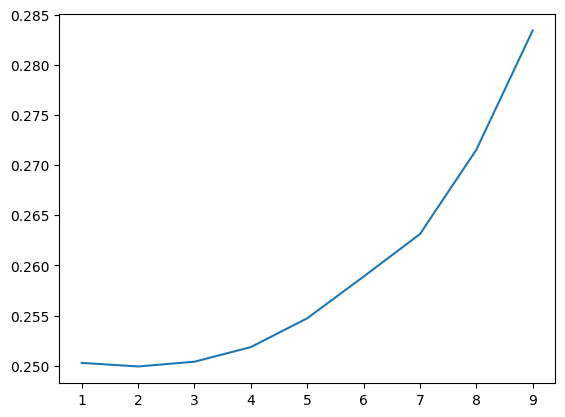

In [22]:
scores = []
for depth in range(1, 10):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    scores.append(mean_squared_error(y_val, y_pred))

plt.plot(range(1, 10), scores)

In [23]:
scores = []
depths = [2, 3, 5, 6]
for depth in depths:
    for estimators in range(100, 201, 10):
        rf = RandomForestRegressor(n_estimators=estimators, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append((depth, estimators,mean_squared_error(y_val, y_pred)))

In [24]:
columns = ["depth", "estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)

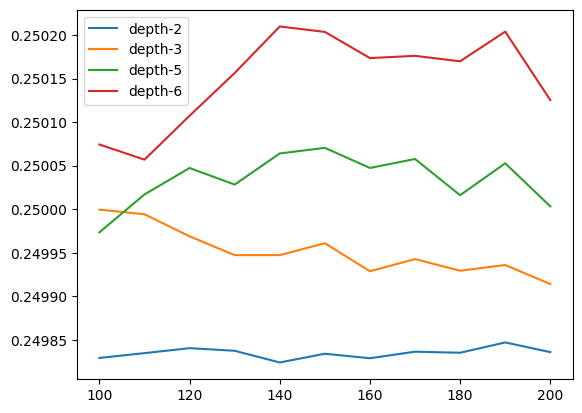

In [25]:
for depth in depths:
    df_subset = df_scores[df_scores["depth"] == depth]
    plt.plot(df_subset["estimators"], df_subset["rmse"], label="depth-%d" % depth)

plt.legend()

In [26]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out()
features= [i.replace("=<", "_") for i in features]
dtrain = xgb.DMatrix(X_train, y_train, feature_names=features)
dval = xgb.DMatrix(X_val, y_val, feature_names=features)

In [27]:
scores_xgb = []
for min_child_weight in range(1, 40, 5):
    for depth in range(1, 5):
        xgb_params['min_child_weight'] = min_child_weight
        xgb_params['max_depth'] = depth
        model = xgb.train(xgb_params, dtrain, num_boost_round=100)
        y_pred = model.predict(dval)
        scores_xgb.append((min_child_weight, depth, mean_squared_error(y_val, y_pred)))

In [28]:
columns = ["min_child_weight", "depth", "mse"]
df_scores = pd.DataFrame(scores_xgb, columns=columns)

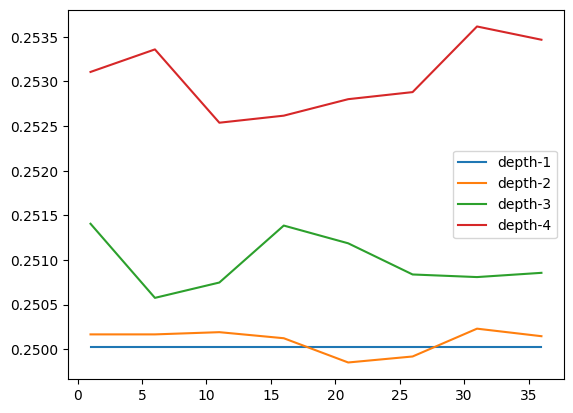

In [29]:
for depth in range(1,5):
    df_subset = df_scores[df_scores["depth"] == depth]
    plt.plot(df_subset["min_child_weight"], df_subset["mse"], label="depth-%d" % depth)

plt.legend()